In [1]:
library(Seurat)
library(patchwork)
library(tidyverse)
library(magrittr)
library(future)

set.seed(1515)
options(future.globals.maxSize = 80000 * 1024^2)
plan("multicore", workers = 16)
plan()

Attaching SeuratObject

Attaching sp

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




multicore:
- args: function (..., workers = 16, envir = parent.frame())
- tweaked: TRUE
- call: plan("multicore", workers = 16)

In [2]:
# 1.1 Load count matrix from CellRanger

# step1 list sample directories ----------------------------------------------
# count
dir.ls1 <- list.dirs(path = '/workdir/wangph/proj/20220418_TB/SC/2.count',
            full.names = T,
            recursive = F)
dir.ls1 <- dir.ls1[c(1: 3, 5:11)]
dir.ls1 %<>% map( ~ paste0(.x, "/outs/filtered_feature_bc_matrix"))
# aggr
dir.ls2 <- c("/workdir/wangph/proj/20220418_TB/SC/2.multi/159611-S/outs/per_sample_outs/159611-S/count/sample_feature_bc_matrix", '/workdir/wangph/proj/20220418_TB/SC/2.multi/167881-S/outs/per_sample_outs/167881-S/count/sample_feature_bc_matrix')

dir.ls = c(dir.ls1, dir.ls2)
names(dir.ls) <- c('159611-S3', '166390-S3', '166457-S3', # '166495-S3', 
                   '166682-S3', '166757-S3','166842-S3', '166846-S3', '166993-S3', '166998-S3', '167126-S3',
                   '159611-S5', '167881-S5')

# step2 check whether dir exist -------------------------------------------
dir.ls %>% map( ~ dir.exists(.x))

# step3 create seurat per samples -----------------------------------------
obj.ls <- dir.ls %>% map( ~ Read10X(.x)) %>% map( ~ CreateSeuratObject(.x, min.cells = 10, min.features = 0))

$`159611-S3`
[1] TRUE

$`166390-S3`
[1] TRUE

$`166457-S3`
[1] TRUE

$`166682-S3`
[1] TRUE

$`166757-S3`
[1] TRUE

$`166842-S3`
[1] TRUE

$`166846-S3`
[1] TRUE

$`166993-S3`
[1] TRUE

$`166998-S3`
[1] TRUE

$`167126-S3`
[1] TRUE

$`159611-S5`
[1] TRUE

$`167881-S5`
[1] TRUE

In [3]:
sample = names(dir.ls)
library <- gsub('^.*\\-', '', sample)
patient <- gsub('\\-.*$', '', sample)
tissue = c('Lung', 'Lung', 'Bone', 'Thoracic wall',
           'Lymph', 'Lung', 'Bone',
           'Lymph', 'Lymph', 'Bone',
           'Lung', 'Lymph')
pathogen = rep('TB', 12)

for(i in 1:length(obj.ls)){
  #给细胞barcode加个前缀，防止合并后barcode重名
  obj.ls[[i]] <- RenameCells(obj.ls[[i]], add.cell.id = sample[i])
  #加信息
  obj.ls[[i]][["sample"]]  = sample[i]
  obj.ls[[i]][["library"]]  = library[i]
  obj.ls[[i]][["patient"]]  = patient[i]
  obj.ls[[i]][["tissue"]]  = tissue[i]
  obj.ls[[i]][["pathogen"]]  = pathogen[i]
  #计算线粒体基因比例r
  if(T){    
    obj.ls[[i]][["percent.mt"]] <- PercentageFeatureSet(obj.ls[[i]], pattern = "^MT-") 
  }
  #计算核糖体基因比例
  if(T){
    obj.ls[[i]][["percent.rb"]] <- PercentageFeatureSet(obj.ls[[i]], pattern = "^RP[SL]")
  }
  #计算红细胞基因比例
  if(T){
    HB.genes <- c("HBA1","HBA2","HBB","HBD","HBE1","HBG1","HBG2","HBM","HBQ1","HBZ")
    HB.genes <- CaseMatch(HB.genes, rownames(obj.ls[[i]]))
    obj.ls[[i]][["percent.hb"]]<-PercentageFeatureSet(obj.ls[[i]], features=HB.genes) 
  }
}

In [4]:
saveRDS(obj.ls, file = "/workdir/wangph/proj/20220418_TB/SC/5.seurat/v7-12sample-normal/1.1.list-raw-20220811.rds")

In [5]:
# 1.3 Merge individuals

combined <- merge(x = obj.ls[[1]], y = obj.ls[2:length(obj.ls)])
combined

An object of class Seurat 
23668 features across 155645 samples within 1 assay 
Active assay: RNA (23668 features, 0 variable features)

In [6]:
scrublet_output = read.csv('/workdir/wangph/proj/20220418_TB/SC/4.scrublet/scrublet_doublet_prediction_EDR0.1-v7.csv')

meta = combined@meta.data
meta = merge(meta, scrublet_output, by.x = 'row.names', by.y = 'barcodes', all.x = TRUE, all.y = FALSE)
rownames(meta) = meta$Row.names
meta = meta[, 2:ncol(meta)]

combined@meta.data = meta

In [7]:
head(combined@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,sample,library,patient,tissue,pathogen,percent.mt,percent.rb,percent.hb,score.Scrublet,prediction.Scrublet
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
159611-S3_AAACCCAAGAGAAGGT-1,SeuratProject,13578,3127,159611-S3,S3,159611,Lung,TB,3.5424952,9.169244,0,0.04583103,False
159611-S3_AAACCCAAGCATAGGC-1,SeuratProject,2379,1220,159611-S3,S3,159611,Lung,TB,1.8495166,18.831442,0,0.12536443,False
159611-S3_AAACCCAAGCTCCATA-1,SeuratProject,560,367,159611-S3,S3,159611,Lung,TB,2.1428571,16.428571,0,0.14194915,False
159611-S3_AAACCCAAGGCGATAC-1,SeuratProject,5104,1468,159611-S3,S3,159611,Lung,TB,1.9004702,28.369906,0,0.07962016,False
159611-S3_AAACCCACACTGCATA-1,SeuratProject,36200,4783,159611-S3,S3,159611,Lung,TB,3.2099448,9.475138,0,0.14563107,False
159611-S3_AAACCCACATAAGCAA-1,SeuratProject,642,318,159611-S3,S3,159611,Lung,TB,0.3115265,3.271028,0,0.01285930,False


In [8]:
saveRDS(combined, file = "/workdir/wangph/proj/20220418_TB/SC/5.seurat/v7-12sample-normal/1.2.merged-raw-20220811.rds")

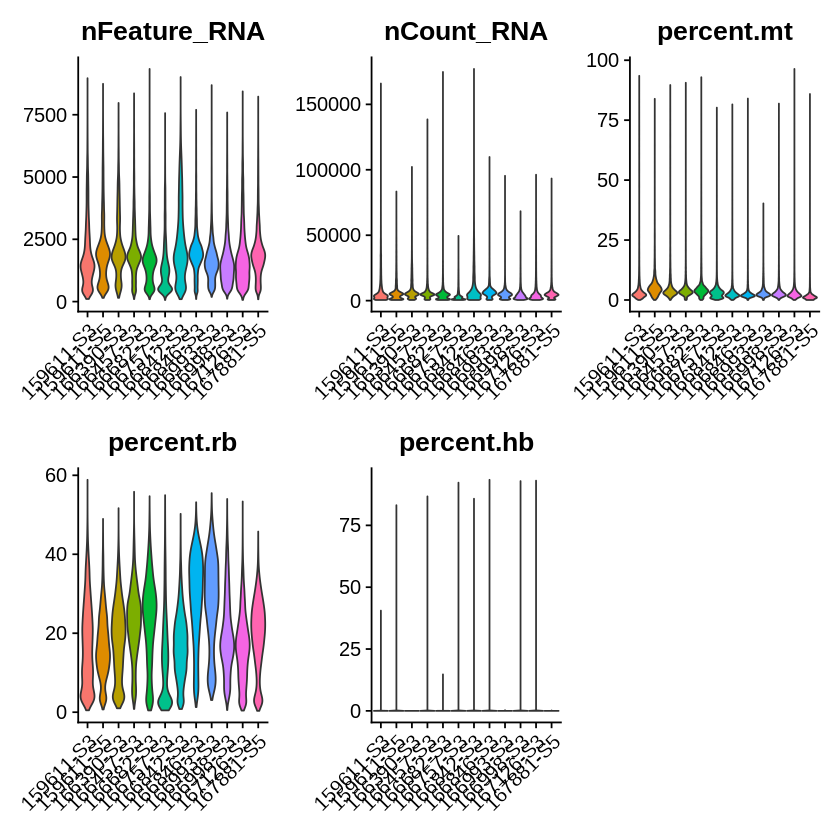

In [9]:
### 绘制质控小提琴图
# 设置可能用到的主题
theme.set2 = theme(axis.title.x=element_blank())
# 设置绘图元素
plot.featrures = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb", "percent.hb")
group = "sample"
# 质控前小提琴图
plots = list()
for(i in seq_along(plot.featrures)){
  plots[[i]] = VlnPlot(combined, group.by=group, pt.size = 0,
                       features = plot.featrures[i]) + theme.set2 + NoLegend()}
violin <- wrap_plots(plots = plots, nrow=2)    
violin

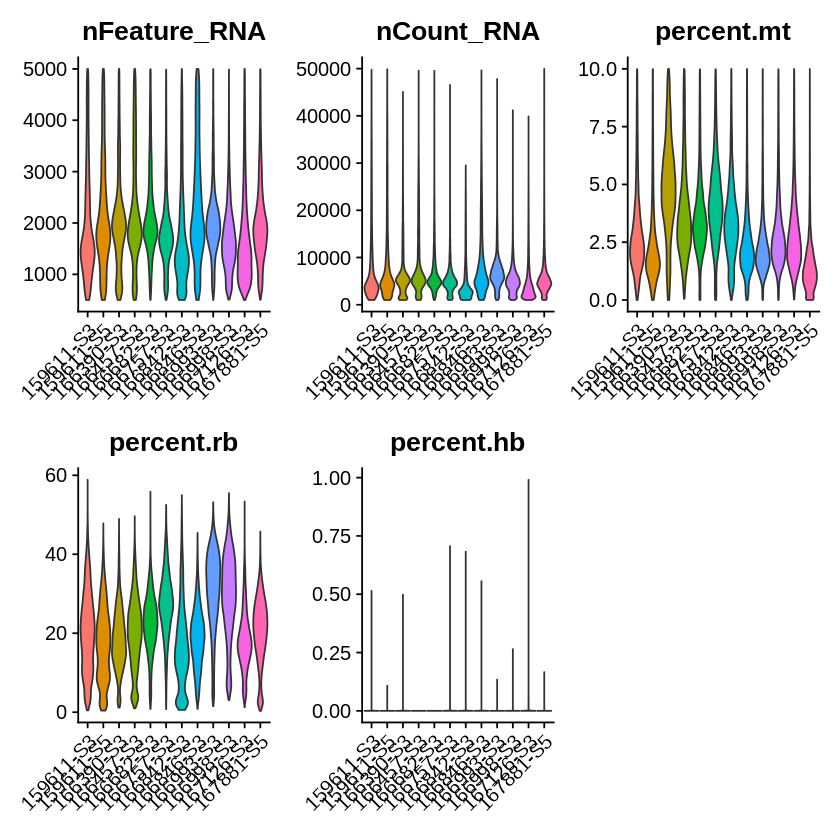

In [10]:
### 设置质控标准
minGene=500
maxGene=5000
minUMI=1000
maxUMI=50000
pctMT=10
pctHB=1

### 数据质控并绘制小提琴图
combined <- subset(combined, subset = nCount_RNA > minUMI & nCount_RNA < maxUMI & 
                   nFeature_RNA > minGene & nFeature_RNA < maxGene & 
                   percent.mt < pctMT & percent.hb < pctHB)
plots = list()
for(i in seq_along(plot.featrures)){
  plots[[i]] = VlnPlot(combined, group.by=group, pt.size = 0,
                       features = plot.featrures[i]) + theme.set2 + NoLegend()}
violin <- wrap_plots(plots = plots, nrow=2)     
violin

In [11]:
combined

An object of class Seurat 
23668 features across 130061 samples within 1 assay 
Active assay: RNA (23668 features, 0 variable features)

In [12]:
# 降维聚类
combined <- NormalizeData(combined) %>% FindVariableFeatures(nfeatures = 3000) %>% ScaleData()
# combined <- SCTransform(combined, return.only.var.genes = FALSE)

Centering and scaling data matrix



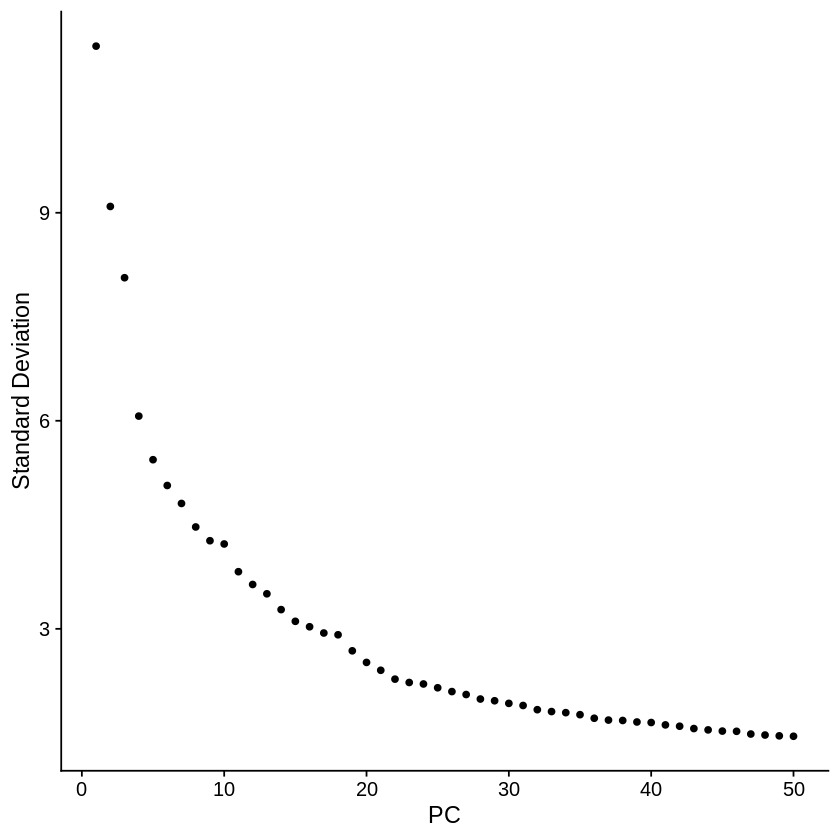

In [13]:
combined <- RunPCA(combined, verbose = F)
ElbowPlot(combined, ndims = 50)

In [14]:
pc.num=1:30
combined <- combined %>% RunTSNE(dims=pc.num) %>% RunUMAP(dims=pc.num)
combined <- FindNeighbors(combined, dims=pc.num) %>% FindClusters()

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
23:39:30 UMAP embedding parameters a = 0.9922 b = 1.112

23:39:30 Read 130061 rows and found 30 numeric columns

23:39:30 Using Annoy for neighbor search, n_neighbors = 30

23:39:30 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:39:54 Writing NN index file to temp file /tmp/RtmptnpAMY/fileb1cb200116f3

23:39:54 Searching Annoy index using 16 threads, search_k = 3000

23:40:00 Annoy recall = 100%

23:40:02 Commencing smooth kNN distance calibration using 16 threads
 with target n_neigh

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 130061
Number of edges: 4521279

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9410
Number of communities: 42
Elapsed time: 70 seconds


1 singletons identified. 41 final clusters.

Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


In [15]:
saveRDS(combined, file = "/workdir/wangph/proj/20220418_TB/SC/5.seurat/v7-12sample-normal/1.3.merged-processed-20220812.rds")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



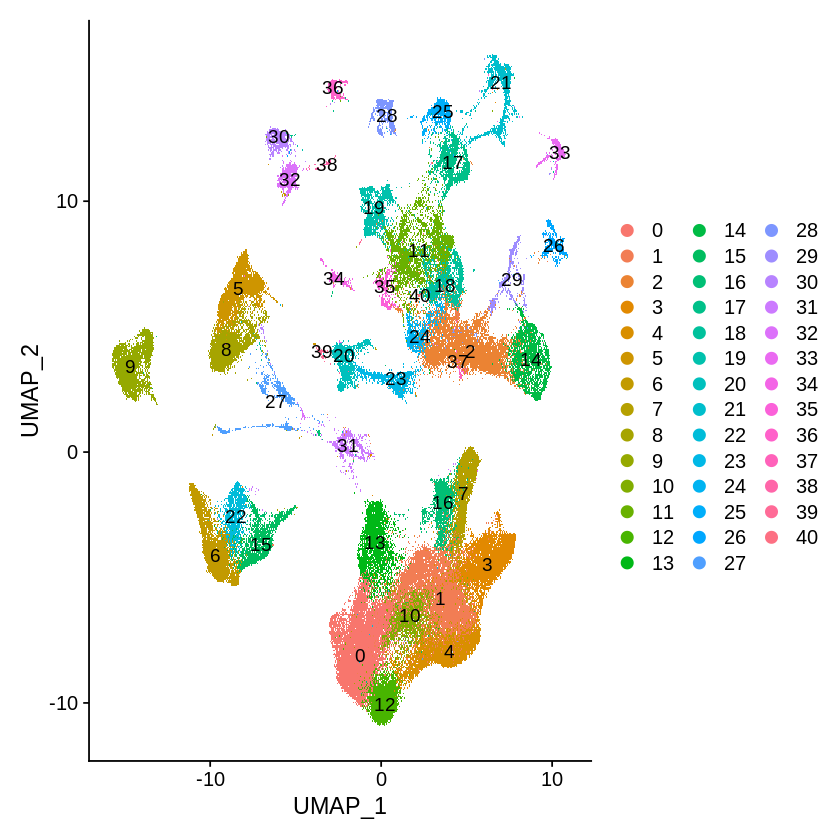

In [16]:
DimPlot(combined, label = T)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



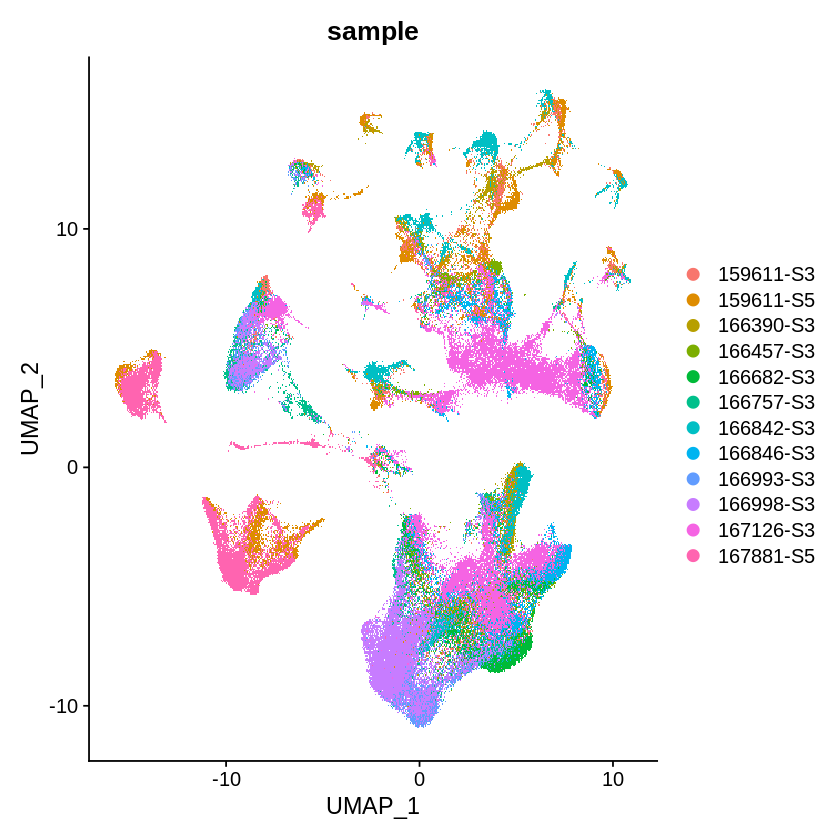

In [17]:
DimPlot(combined, group.by = "sample")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



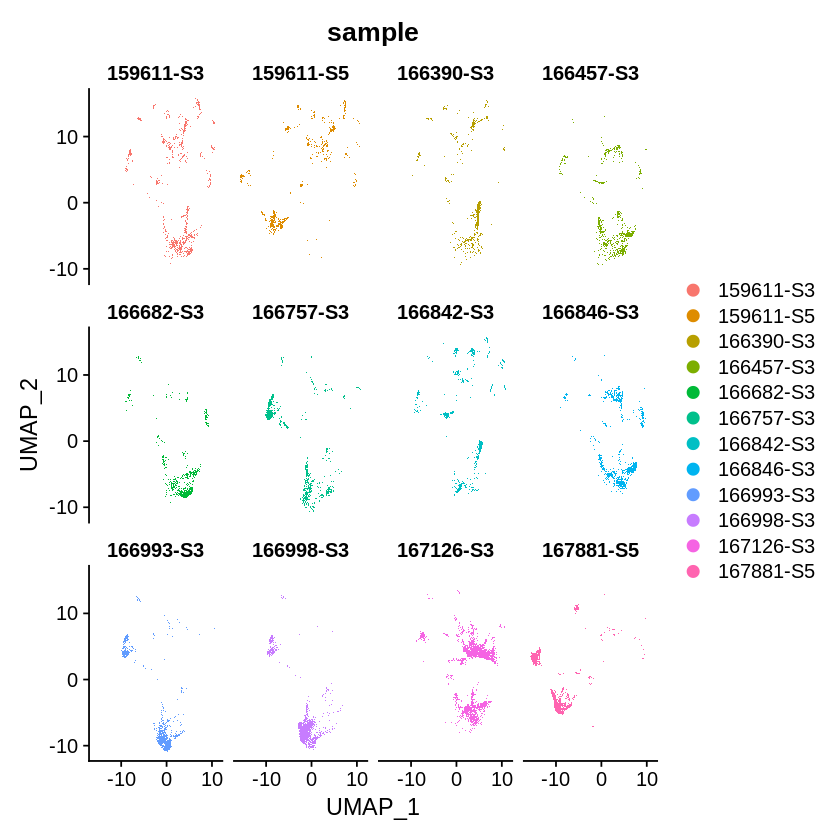

In [18]:
DimPlot(combined, group.by = "sample", split.by = "sample", ncol = 4)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



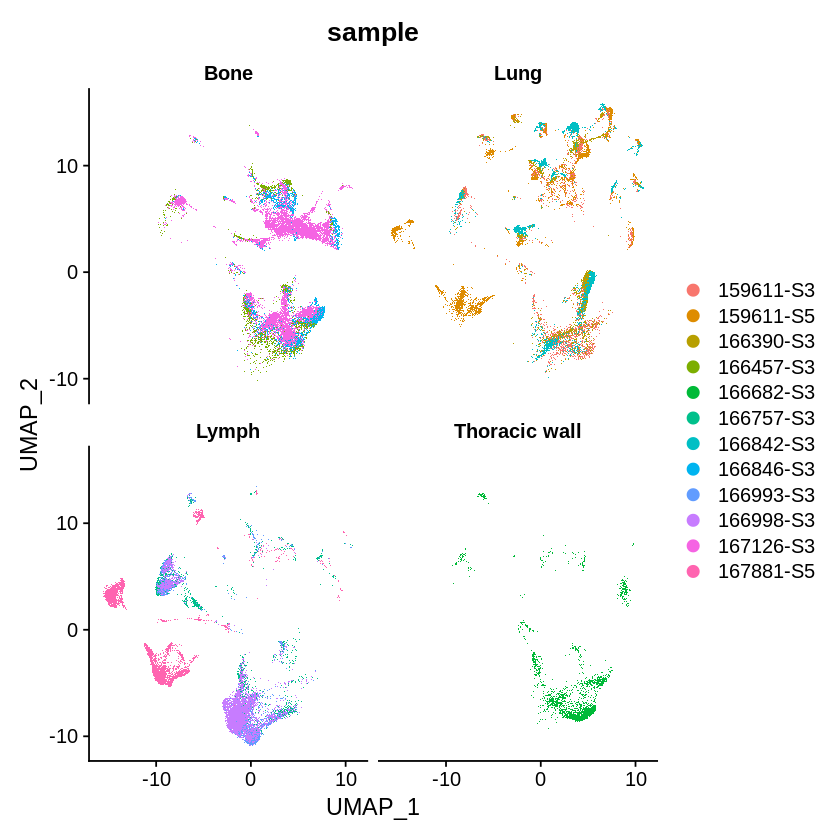

In [19]:
DimPlot(combined, group.by = "sample", split.by = "tissue", ncol = 2)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



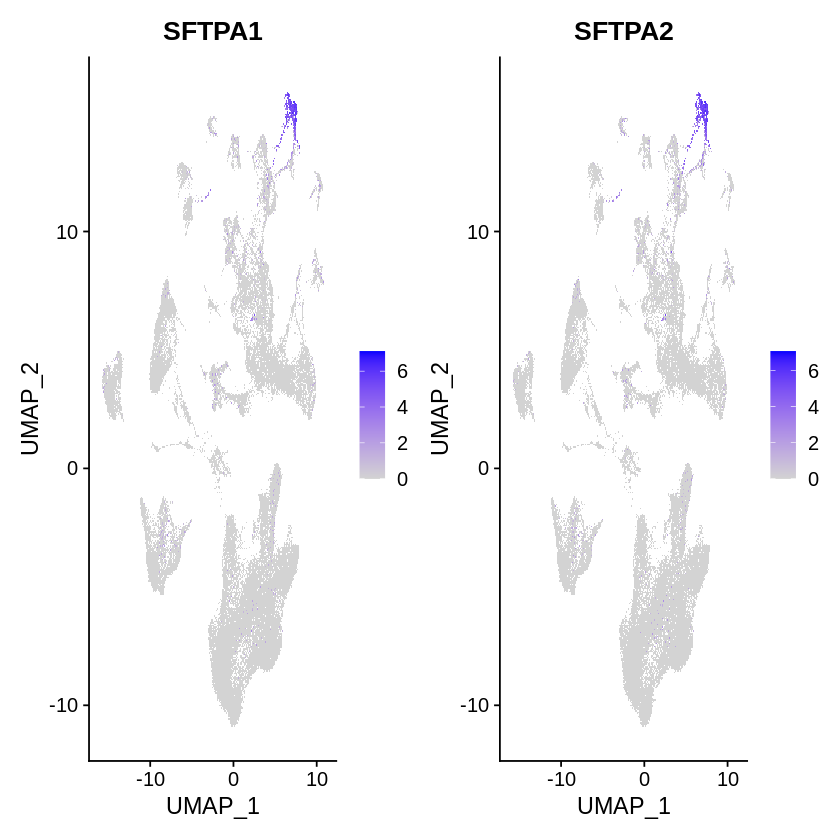

In [20]:
FeaturePlot(combined, reduction = "umap", features = c('SFTPA1', 'SFTPA2'))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



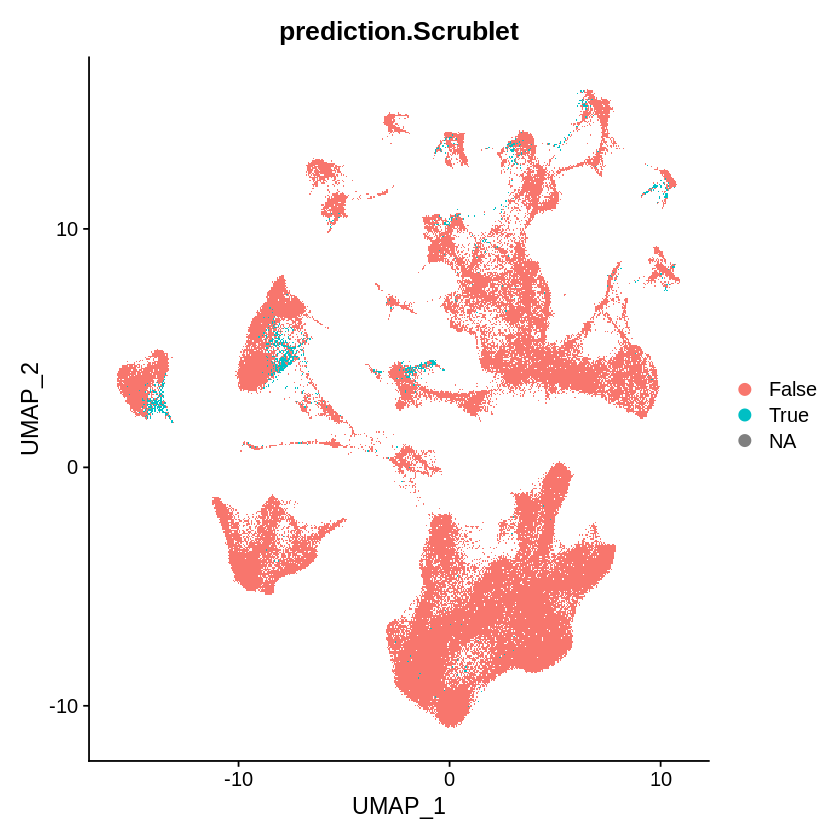

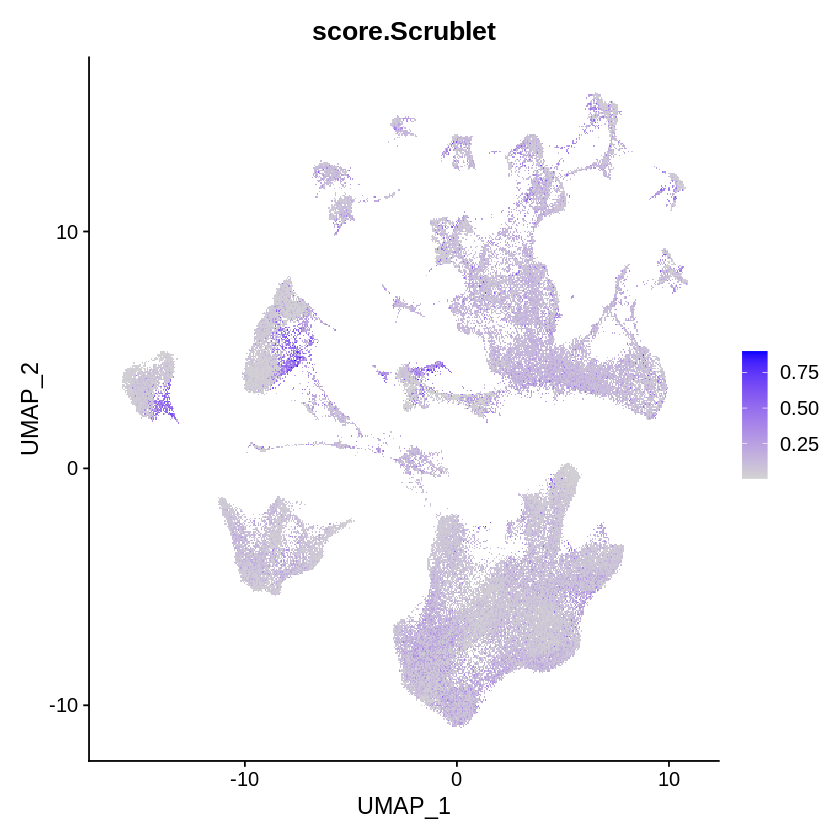

In [21]:
DimPlot(combined, group.by = "prediction.Scrublet")
FeaturePlot(combined, features = 'score.Scrublet')

In [22]:
table(combined@meta.data$prediction.Scrublet)


 False   True 
127703   2357 

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



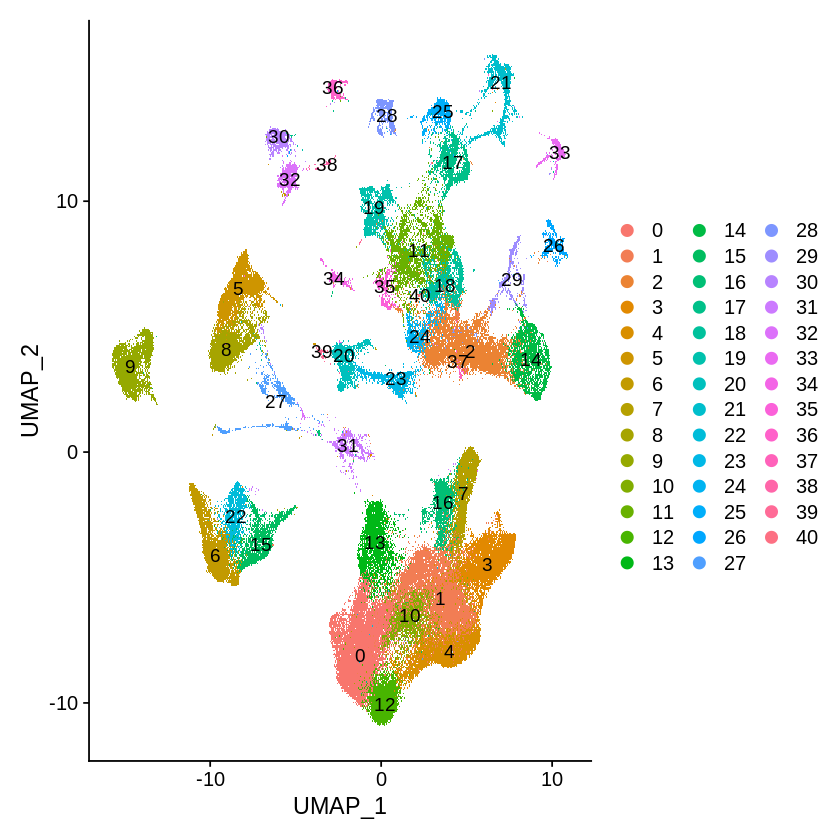

In [23]:
DimPlot(combined, label = T) 